<a href="https://colab.research.google.com/github/macmelon/master/blob/main/Proyecto_malware.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Cargamos las librerias

In [458]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os

In [459]:
import xgboost as xgb 
from sklearn import model_selection # model assesment and model selection strategies
from sklearn import metrics # model evaluation metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
import pydotplus

In [460]:
from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Funciones

In [461]:
#Me voy a montar una función que me permita ver cuanto se repite un determinado valor en cada una de las variables que creo que están agrupadas.
def contar_repeticiones(var_principal, list_fields, df):
  df_pt = pd.pivot_table(df, columns=list_fields, index=[var_principal], aggfunc=['size'], fill_value=0).T
  df_pt = df_pt.astype('bool') #Cambio la var a booleano xq solo me interesa saber si este campo está en más de una agrupación o no.
  df_col = df_pt.reset_index()
  lista_valores = list(df_mw[var_principal].unique())
  return df_col[df_col[lista_valores].sum(axis=1)>1]

In [462]:
#Esta función es una copiada de la tuya pero es que va muy bien.
def OHE(col_name,dataframe):
  _dummy_dataset = pd.get_dummies(dataframe[col_name], prefix = col_name)
  dataframe = pd.concat([dataframe,_dummy_dataset], axis = 1)
  return dataframe.drop([col_name], axis =1)

In [463]:
#Función a la que le paso una lista de campos, me los limpia y me hace un Cast a númerico.
def categorica_to_num(list_fields, dataframe):
  for field in list_fields:
    dataframe[field+'_net'] = dataframe[field].replace('\.','', regex=True).astype(int)
  return dataframe.drop(list_fields, axis =1)

In [464]:
#Me he copiado otra función de un notebook tuyo xq también me va bien para explotar información
def explore_cat_values(dataframe, column,target_col):
  results_df = dataframe[dataframe[target_col] >0].pivot_table(index = column, values = target_col, aggfunc = [len, np.median] )
  results_df.columns = ['transactions', 'median_revenue']
  results_df['n_rows'] = dataframe[column].value_counts()
  results_df['pct_rows'] = dataframe[column].value_counts(normalize = True)
  results_df['pct_transactions'] = results_df['transactions'] / results_df['n_rows']
  return results_df[['n_rows','pct_rows','transactions','pct_transactions','median_revenue']]

In [465]:
#Lo mismo que antes
def set_Other(dataframe, column, num_values):
  top_browsers = dataframe[column].value_counts().head(num_values)
  top_browsers_list = top_browsers.index.to_list()
  top_browsers_list.append('Others') #para todos los demás
  dataframe[column] = pd.Categorical(dataframe[column], categories = top_browsers_list)
  return dataframe[column].fillna('Others')

In [466]:
#Funcion que me muestra la dispersión de un campo así como la corr con el target
def columns_corr(df, list_columns):
  for column in list_columns:
    print('---------------------------------------')
    print(column+':')
    print(df[[column, TARGET]].corr(), end='\n\n')
    print(df[column].value_counts())
    if len(df[column].value_counts())<20:
      plt.figure(figsize = (15,5))
      plt.xticks(rotation=90)
      sns.countplot(data = df_mw, x =column, hue = TARGET);
  return

In [467]:
#Funcion para entrenar el modelo y hacer el split
def training(TARGET, df_):
  dev_df = df_.drop(TARGET, axis=1)
  val_df = df_[TARGET]
  #Separación entre Validición y test/train
  X_val_df, X_tmp, y_val_df, y_tmp = model_selection.train_test_split(
                                        dev_df, # X 
                                        val_df, # y
                                        test_size = 0.20, # tamaño del split aleatorio 
                                        random_state = 42,
                                        stratify = np.array(val_df)
                                     )
  
  #Particionamos el dataset de train y el de test 50/50
  X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                        X_tmp, y_tmp, train_size=0.5, random_state=42,
                                        stratify = np.array(y_tmp))
  
  #Instanciamos el modelo
  dt = DecisionTreeClassifier(
                        max_depth=8, # Importante, regulará el sobreajuste
                        random_state=42)
  
  dt.fit(
    X=X_train, 
    y=y_train)
  return pd.DataFrame(dt.predict(X_test), columns=['Prediction'], index=X_test.index), y_test, X_test, y_val_df, X_val_df, y_train, X_train

### Procedemos a cargar el fichero en un dataframe

In [468]:
file_dir = '/content/gdrive/MyDrive/Master/Machine Learning/Proyecto/'
file_name = 'sample_mmp.csv'

In [469]:
df_mw = pd.read_csv(file_dir+file_name)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (29,42) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


###Primer vistazo a los datos.

In [470]:
#Mostramos todas las filas para ver todos los campos
pd.set_option("max_rows", 100)
df_mw.head().T

,0,1,2,3,4
Unnamed: 0,8427007,8829090,2731904,1359513,236059
MachineIdentifier,f1cd864e97bae82bdf96523e1a539121,fd5ba6f5b75325ec0423a6c67cc75942,4e628391e7cc7c482fb3286f486dbd25,270a2e9d028144a4df12a9e3da79fba5,06ca8fa8d32c2abdc5b3577d676b3269
ProductName,win8defender,win8defender,win8defender,win8defender,win8defender
EngineVersion,1.1.15100.1,1.1.15100.1,1.1.15100.1,1.1.15200.1,1.1.15200.1
AppVersion,4.18.1807.18075,4.18.1807.18075,4.9.10586.1106,4.18.1807.18075,4.18.1807.18075
AvSigVersion,1.273.1234.0,1.273.1282.0,1.273.781.0,1.275.1639.0,1.275.511.0
IsBeta,0,0,0,0,0
RtpStateBitfield,7.0,7.0,7.0,7.0,7.0
IsSxsPassiveMode,0,0,0,0,0
DefaultBrowsersIdentifier,NaN,NaN,NaN,NaN,NaN


In [471]:
#Mostramos de que tipo son los campos para ver que todo esté ok.
df_mw.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 84 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Unnamed: 0                                         500000 non-null  int64  
 1   MachineIdentifier                                  500000 non-null  object 
 2   ProductName                                        500000 non-null  object 
 3   EngineVersion                                      500000 non-null  object 
 4   AppVersion                                         500000 non-null  object 
 5   AvSigVersion                                       500000 non-null  object 
 6   IsBeta                                             500000 non-null  int64  
 7   RtpStateBitfield                                   498168 non-null  float64
 8   IsSxsPassiveMode                                   500000 non-null  int64 

##Vamos a utilizar MachineIdentifier como Indice

In [472]:
df_mw['MachineIdentifier'].describe() 

count                               500000
unique                              500000
top       f1cd864e97bae82bdf96523e1a539121
freq                                     1
Name: MachineIdentifier, dtype: object

###Nos guardamos la información de los campos del dataset para poder ir marcando los campos explorados

In [473]:
df_mw_desc = df_mw.describe(include='all').T
df_mw_desc.to_excel('dfmw_description.xlsx')
#files.download('dfmw_description.xlsx')

In [474]:
df_mw.head().T

,0,1,2,3,4
Unnamed: 0,8427007,8829090,2731904,1359513,236059
MachineIdentifier,f1cd864e97bae82bdf96523e1a539121,fd5ba6f5b75325ec0423a6c67cc75942,4e628391e7cc7c482fb3286f486dbd25,270a2e9d028144a4df12a9e3da79fba5,06ca8fa8d32c2abdc5b3577d676b3269
ProductName,win8defender,win8defender,win8defender,win8defender,win8defender
EngineVersion,1.1.15100.1,1.1.15100.1,1.1.15100.1,1.1.15200.1,1.1.15200.1
AppVersion,4.18.1807.18075,4.18.1807.18075,4.9.10586.1106,4.18.1807.18075,4.18.1807.18075
AvSigVersion,1.273.1234.0,1.273.1282.0,1.273.781.0,1.275.1639.0,1.275.511.0
IsBeta,0,0,0,0,0
RtpStateBitfield,7.0,7.0,7.0,7.0,7.0
IsSxsPassiveMode,0,0,0,0,0
DefaultBrowsersIdentifier,NaN,NaN,NaN,NaN,NaN


In [475]:
#Añadimos el target
TARGET = 'HasDetections'

In [476]:
#Vemos que está muy distribuido, casi la mitad de los registros son malware
df_mw[TARGET].value_counts()

0    250047
1    249953
Name: HasDetections, dtype: int64

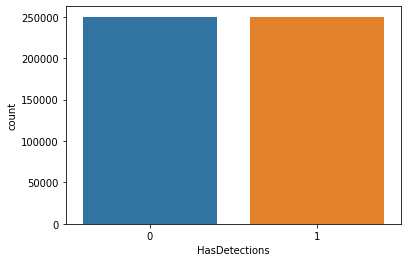

In [477]:
sns.countplot(data=df_mw, x=TARGET)

In [478]:
df_mw[TARGET].describe()

count    500000.000000
mean          0.499906
std           0.500000
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: HasDetections, dtype: float64

##Vamos con las Categoricas

In [479]:
df_mw.describe(exclude = np.number).T

,count,unique,top,freq
MachineIdentifier,500000,500000,f1cd864e97bae82bdf96523e1a539121,1
ProductName,500000,3,win8defender,494604
EngineVersion,500000,53,1.1.15200.1,216491
AppVersion,500000,95,4.18.1807.18075,288809
AvSigVersion,500000,6455,1.273.1420.0,5771
Platform,500000,4,windows10,483048
Processor,500000,3,x64,454423
OsVer,500000,21,10.0.0.0,483830
OsPlatformSubRelease,500000,9,rs4,220779
OsBuildLab,499999,453,17134.1.amd64fre.rs4_release.180410-1804,206436


In [480]:
df_mw['ProductName'].value_counts()

win8defender     494604
mse                5395
mseprerelease         1
Name: ProductName, dtype: int64

In [481]:
#Parece ser como si hubiera 2 grupos diferenciados, uno... lo que tiene que ver con el programa que escanea en busca de virus... ProductName, EngineVersion, AppVersion y AvSigVersion
#Otro el que tiene que ver con el S.O. Platform, Processor, OsVer, OsPlatformSubRelease, OsBuildLab

In [482]:
campos_agg = ['EngineVersion', 'AppVersion','AvSigVersion']
contar_repeticiones('ProductName', campos_agg, df_mw)

ProductName,level_0,EngineVersion,AppVersion,AvSigVersion,mse,mseprerelease,win8defender
3232,size,1.1.13804.0,4.10.209.0,1.245.730.0,True,False,True
4182,size,1.1.14003.0,4.10.209.0,1.249.1077.0,True,False,True
5697,size,1.1.14202.0,4.10.209.0,1.253.74.0,True,False,True
6238,size,1.1.14305.0,4.10.209.0,1.255.195.0,True,False,True
6683,size,1.1.14306.0,4.10.209.0,1.257.1417.0,True,False,True
...,...,...,...,...,...,...,...
45669,size,1.1.15300.6,4.10.209.0,1.277.41.0,True,False,True
45671,size,1.1.15300.6,4.10.209.0,1.277.46.0,True,False,True
45672,size,1.1.15300.6,4.10.209.0,1.277.48.0,True,False,True
45673,size,1.1.15300.6,4.10.209.0,1.277.49.0,True,False,True


In [483]:
#El resultado nos arroja que los valores no son únicos por columna así que no podemos combinar los campos al haber más de una posible combinación para cada uno de los productos. 
#Pasaremos a númericos los campos Engineversion AppVersion y AvSugVersion
#Haremos un OHE del campo ProductName.

In [484]:
#Me creo una lista con los valores de las columnas categoricas
list_cat=[]
list_cat = df_mw.describe(exclude = np.number).columns.tolist() 

In [485]:
#Añado el target
list_cat.append(TARGET)

In [486]:
#Voy a hacer una copia del Dataframe original para no tener que volver al principio a solucionar algo.
df_mw_limpieza = df_mw[list_cat].copy()
df_mw_limpieza = OHE('ProductName', df_mw_limpieza) 

In [487]:
df_mw_limpieza

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,Platform,Processor,OsVer,OsPlatformSubRelease,OsBuildLab,SkuEdition,PuaMode,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_ProcessorClass,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing,HasDetections,ProductName_mse,ProductName_mseprerelease,ProductName_win8defender
0,f1cd864e97bae82bdf96523e1a539121,1.1.15100.1,4.18.1807.18075,1.273.1234.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,NaN,RequireAdmin,Desktop,Windows.Desktop,NaN,HDD,AllinOne,Desktop,NaN,10.0.17134.165,amd64,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,OEM:DM,Retail,1,0,0,1
1,fd5ba6f5b75325ec0423a6c67cc75942,1.1.15100.1,4.18.1807.18075,1.273.1282.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,NaN,RequireAdmin,Notebook,Windows.Desktop,NaN,HDD,Notebook,Mobile,lion,10.0.17134.165,amd64,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,OEM:DM,Retail,0,0,0,1
2,4e628391e7cc7c482fb3286f486dbd25,1.1.15100.1,4.9.10586.1106,1.273.781.0,windows10,x64,10.0.0.0,th2,10586.1176.amd64fre.th2_release_sec.170913-1848,Home,NaN,RequireAdmin,Convertible,Windows.Desktop,NaN,SSD,Notebook,Mobile,lion,10.0.10586.1176,amd64,th2_release_sec,Core,CORE,Update,Notify,IS_GENUINE,Retail,Retail,0,0,0,1
3,270a2e9d028144a4df12a9e3da79fba5,1.1.15200.1,4.18.1807.18075,1.275.1639.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,NaN,NaN,Notebook,Windows.Desktop,NaN,SSD,Notebook,Mobile,NaN,10.0.17134.286,amd64,rs4_release,Core,CORE,IBSClean,FullAuto,IS_GENUINE,Retail,Retail,1,0,0,1
4,06ca8fa8d32c2abdc5b3577d676b3269,1.1.15200.1,4.18.1807.18075,1.275.511.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Pro,NaN,RequireAdmin,Notebook,Windows.Desktop,NaN,HDD,Portable,Mobile,NaN,10.0.17134.228,amd64,rs4_release,Professional,PROFESSIONAL,Update,FullAuto,IS_GENUINE,OEM:DM,Retail,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,a739cacc292f3f1e745827c1ca6c6ada,1.1.15200.1,4.18.1807.18075,1.275.1090.0,windows10,x64,10.0.0.0,rs3,16299.431.amd64fre.rs3_release_svc_escrow.1805...,Home,NaN,RequireAdmin,Convertible,Windows.Desktop,NaN,HDD,Convertible,Mobile,lion,10.0.16299.492,amd64,rs3_release_svc_escrow,Core,CORE,Upgrade,Notify,IS_GENUINE,OEM:DM,Retail,0,0,0,1
499996,a4c232d528d98343e8f1b73650da7b82,1.1.15100.1,4.18.1807.18075,1.273.1620.0,windows10,x64,10.0.0.0,rs3,16299.15.amd64fre.rs3_release.170928-1534,Home,NaN,Off,Notebook,Windows.Desktop,NaN,SSD,Laptop,Mobile,NaN,10.0.16299.309,amd64,rs3_release,Core,CORE,Upgrade,UNKNOWN,INVALID_LICENSE,Retail,Retail,0,0,0,1
499997,fd16cd542d660848d272e4552bcccb1e,1.1.15300.5,4.13.17134.112,1.275.1343.0,windows10,x86,10.0.0.0,rs4,17134.1.x86fre.rs4_release.180410-1804,Pro,NaN,NaN,Desktop,Windows.Desktop,NaN,HDD,MiniTower,Desktop,NaN,10.0.17134.285,x86,rs4_release,Professional,PROFESSIONAL,Upgrade,FullAuto,IS_GENUINE,Retail,Retail,0,0,0,1
499998,fa0841f8f6147de7c3d287e05270ed42,1.1.15100.1,4.14.17639.18041,1.273.483.0,windows10,x64,10.0.0.0,rs3,16299.15.amd64fre.rs3_release.170928-1534,Pro,NaN,NaN,Notebook,Windows.Desktop,NaN,HDD,Notebook,Mobile,NaN,10.0.16299.371,amd64,rs3_release,Professional,PROFESSIONAL,Upgrade,FullAuto,IS_GENUINE,Retail,Retail,0,0,0,1


In [488]:
list_f = ['EngineVersion', 'AppVersion','AvSigVersion']
df_mw_limpieza = categorica_to_num(list_f, df_mw_limpieza)

In [489]:
df_mw_limpieza.head().T

,0,1,2,3,4
MachineIdentifier,f1cd864e97bae82bdf96523e1a539121,fd5ba6f5b75325ec0423a6c67cc75942,4e628391e7cc7c482fb3286f486dbd25,270a2e9d028144a4df12a9e3da79fba5,06ca8fa8d32c2abdc5b3577d676b3269
Platform,windows10,windows10,windows10,windows10,windows10
Processor,x64,x64,x64,x64,x64
OsVer,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0,10.0.0.0
OsPlatformSubRelease,rs4,rs4,th2,rs4,rs4
OsBuildLab,17134.1.amd64fre.rs4_release.180410-1804,17134.1.amd64fre.rs4_release.180410-1804,10586.1176.amd64fre.th2_release_sec.170913-1848,17134.1.amd64fre.rs4_release.180410-1804,17134.1.amd64fre.rs4_release.180410-1804
SkuEdition,Pro,Pro,Home,Home,Pro
PuaMode,NaN,NaN,NaN,NaN,NaN
SmartScreen,RequireAdmin,RequireAdmin,RequireAdmin,NaN,RequireAdmin
Census_MDC2FormFactor,Desktop,Notebook,Convertible,Notebook,Notebook


In [490]:
#Quiero hacer lo mismo con estos 3 campos.
campos_agg = ['Processor', 'OsVer','OsPlatformSubRelease']
contar_repeticiones('Platform', campos_agg, df_mw) #Voy a ver cuantas veces se repite esta casuistica. no puedo añadir 'OsBuildLab' xq el número de combinaciones crece mucho.

Platform,level_0,Processor,OsVer,OsPlatformSubRelease,windows10,windows2016,windows7,windows8
3,size,x64,10.0.0.0,rs1,True,True,False,False


In [491]:
#Lo que voy a hacer es agrupar estos 4 campos que están relacionados y darles un peso 
list_platform_group = ['Platform', 'Processor', 'OsVer','OsPlatformSubRelease']
df_mw_platform_value = df_mw[['Platform', 'Processor', 'OsVer','OsPlatformSubRelease']].value_counts()

In [492]:
#Me monto un nuevo DF con el número de repeticiones
df_mw_platform_value = df_mw_platform_value.reset_index()

In [493]:
df_mw_platform_value.head(5)


,Platform,Processor,OsVer,OsPlatformSubRelease,0
0,windows10,x64,10.0.0.0,rs4,206424
1,windows10,x64,10.0.0.0,rs3,126505
2,windows10,x64,10.0.0.0,rs2,39906
3,windows10,x64,10.0.0.0,rs1,34023
4,windows10,x64,10.0.0.0,th2,18910


In [494]:
#Junto los DFs creando un nuevo campo 
df_mw_limpieza = df_mw_limpieza.merge(df_mw_platform_value)
df_mw_limpieza.rename(columns={0:'Platform_Processor_OsVer_OsPlatformSubRelease'},inplace=True) 

In [495]:
#Renombro el campo y borro los campos agrupados.
df_mw_limpieza.rename(columns={0:'Platform_Processor_OsVer_OsPlatformSubRelease'},inplace=True)

In [496]:
df_mw_limpieza = df_mw_limpieza.drop(list_platform_group, axis =1)
df_mw_limpieza.head(1)

,MachineIdentifier,OsBuildLab,SkuEdition,PuaMode,SmartScreen,Census_MDC2FormFactor,Census_DeviceFamily,Census_ProcessorClass,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing,HasDetections,ProductName_mse,ProductName_mseprerelease,ProductName_win8defender,EngineVersion_net,AppVersion_net,AvSigVersion_net,Platform_Processor_OsVer_OsPlatformSubRelease
0,f1cd864e97bae82bdf96523e1a539121,17134.1.amd64fre.rs4_release.180410-1804,Pro,NaN,RequireAdmin,Desktop,Windows.Desktop,NaN,HDD,AllinOne,Desktop,NaN,10.0.17134.165,amd64,rs4_release,Professional,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,OEM:DM,Retail,1,0,0,1,11151001,418180718075,127312340,206424


In [497]:
#Con Sku Edition simplemente hacemos un OHE
df_mw_limpieza['SkuEdition'].value_counts()
df_mw_limpieza = OHE('SkuEdition', df_mw_limpieza) 

In [498]:
#PuaMode
explore_cat_values(df_mw_limpieza, 'PuaMode',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
PuaMode,,,,,
on,126,1.0,95,0.753968,1


In [499]:
#Este campo lo pasamos directamente a 1 y 0's.
df_mw_limpieza['PuaMode'] = df_mw_limpieza['PuaMode'].replace('on', '1').fillna(0).astype(int)

In [500]:
#SmartScreem
df_mw_limpieza['SmartScreen'].value_counts()

RequireAdmin    241594
ExistsNotSet     58497
Off              10388
Warn              7530
Prompt            1950
Block             1274
off                 75
On                  53
&#x02;              20
&#x01;              14
on                   8
requireadmin         1
Name: SmartScreen, dtype: int64

In [501]:
explore_cat_values(df_mw_limpieza, 'SmartScreen',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
SmartScreen,,,,,
&#x01;,14,0.000044,6,0.428571,1
&#x02;,20,0.000062,11,0.550000,1
Block,1274,0.003964,640,0.502355,1
ExistsNotSet,58497,0.182005,47115,0.805426,1
Off,10388,0.032321,5055,0.486619,1
On,53,0.000165,36,0.679245,1
Prompt,1950,0.006067,928,0.475897,1
RequireAdmin,241594,0.751683,105890,0.438297,1
Warn,7530,0.023428,4306,0.571846,1


In [502]:
#Me quedo con los 6 primeros valores que son relevantes, reemplazo valores que son iguales pero que tienen un problema con el Ucase
df_mw_limpieza['SmartScreen'] = df_mw_limpieza['SmartScreen'].replace('off','Off')
df_mw_limpieza['SmartScreen'] = df_mw_limpieza['SmartScreen'].replace('on','On')
df_mw_limpieza['SmartScreen'].value_counts()

RequireAdmin    241594
ExistsNotSet     58497
Off              10463
Warn              7530
Prompt            1950
Block             1274
On                  61
&#x02;              20
&#x01;              14
requireadmin         1
Name: SmartScreen, dtype: int64

In [503]:
type(df_mw_limpieza['SmartScreen'])

pandas.core.series.Series

In [504]:
#Categorizo las diferentes columnas en grupos más pequeños
df_mw_limpieza['SmartScreen'].fillna('unknown', inplace=True)
df_mw_limpieza['SmartScreen'] = set_Other(df_mw_limpieza, 'SmartScreen', 7)


In [505]:
#OHE de la variable
df_mw_limpieza = OHE('SmartScreen', df_mw_limpieza) 

In [506]:
explore_cat_values(df_mw_limpieza, 'Census_MDC2FormFactor',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
Census_MDC2FormFactor,,,,,
AllInOne,16372,0.032744,8384,0.512094,1
Convertible,22369,0.044738,11025,0.492870,1
Desktop,109527,0.219054,57306,0.523213,1
Detachable,16802,0.033604,6351,0.377991,1
LargeServer,50,0.000100,10,0.200000,1
LargeTablet,3645,0.007290,1138,0.312209,1
MediumServer,192,0.000384,62,0.322917,1
Notebook,320948,0.641896,161411,0.502919,1
PCOther,7800,0.015600,3715,0.476282,1


In [507]:
#Agrupo los valores más altos de 1k
df_mw_limpieza['Census_MDC2FormFactor'] = set_Other(df_mw_limpieza, 'Census_MDC2FormFactor', 8)
#OHE de la variable
df_mw_limpieza = OHE('Census_MDC2FormFactor', df_mw_limpieza) 

In [508]:
#Esta valiable la paso a 1's y 0's
explore_cat_values(df_mw_limpieza, 'Census_DeviceFamily',TARGET)
df_mw_limpieza['Census_DeviceFamily'].value_counts()

Windows.Desktop    499183
Windows.Server        816
Windows                 1
Name: Census_DeviceFamily, dtype: int64

In [509]:
df_mw_limpieza['Census_DeviceFamily'] = df_mw_limpieza['Census_DeviceFamily'].replace('Windows.Desktop', '1')
df_mw_limpieza['Census_DeviceFamily'][df_mw_limpieza['Census_DeviceFamily']!='1']='0'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [510]:
df_mw_limpieza['Census_DeviceFamily'] = df_mw_limpieza['Census_DeviceFamily'].astype(int)

In [511]:
df_mw_limpieza['Census_DeviceFamily'].value_counts()

1    499183
0       817
Name: Census_DeviceFamily, dtype: int64

In [512]:
#Census_ProcessorClass
explore_cat_values(df_mw_limpieza, 'Census_ProcessorClass',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
Census_ProcessorClass,,,,,
high,340,0.163305,211,0.620588,1
low,546,0.262248,287,0.525641,1
mid,1196,0.574448,679,0.567726,1


In [513]:
list_OHE = ['Census_ProcessorClass'] #Me creo una lista para hacer un grupo de variables de golpe.

In [514]:
#Census_ProcessorClass
explore_cat_values(df_mw_limpieza, 'Census_PrimaryDiskTypeName',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
Census_PrimaryDiskTypeName,,,,,
HDD,325429,0.651782,164762,0.506292,1
SSD,138155,0.276702,68821,0.498143,1
UNKNOWN,20083,0.040223,9019,0.449086,1
Unspecified,15624,0.031292,7000,0.448029,1


In [515]:
list_OHE.append('Census_PrimaryDiskTypeName')

In [516]:
explore_cat_values(df_mw_limpieza, 'Census_ChassisTypeName',TARGET) # Se parece mucho a Census_MDC2FormFactor, tiene valores nulos y algunos extraños, así que me quedaré con la otra columna prescindiendo de esta.

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
Census_ChassisTypeName,,,,,
0,5,0.000010,2,0.400000,1
30,11,0.000022,3,0.272727,1
31,2,0.000004,2,1.000000,1
32,1,0.000002,1,1.000000,1
35,3,0.000006,1,0.333333,1
AllinOne,11407,0.022816,5831,0.511177,1
BusExpansionChassis,38,0.000076,15,0.394737,1
Convertible,4685,0.009371,2252,0.480683,1
Desktop,104979,0.209974,55150,0.525343,1


In [517]:
list_drop = ['Census_ChassisTypeName']

In [518]:
##Census_PowerPlatformRoleName
explore_cat_values(df_mw_limpieza, 'Census_PowerPlatformRoleName',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
Census_PowerPlatformRoleName,,,,,
AppliancePC,212,0.000424,46,0.216981,1
Desktop,116054,0.232109,60942,0.525118,1
EnterpriseServer,406,0.000812,177,0.435961,1
Mobile,346378,0.692759,173910,0.502082,1
PerformanceServer,4,0.000008,3,0.750000,1
SOHOServer,2062,0.004124,1024,0.496605,1
Slate,27475,0.054950,10082,0.366952,1
UNKNOWN,1172,0.002344,571,0.487201,1
Workstation,6235,0.012470,3198,0.512911,1


In [519]:
#Agrupo los valores más altos de 1k
df_mw_limpieza['Census_PowerPlatformRoleName'] = set_Other(df_mw_limpieza, 'Census_PowerPlatformRoleName', 6)
#OHE de la variable
df_mw_limpieza = OHE('Census_PowerPlatformRoleName', df_mw_limpieza) 

In [520]:
explore_cat_values(df_mw_limpieza, 'Census_InternalBatteryType',TARGET) #Tipo de bateria. Igual nos podemos quedar con las de litio solo, parece que son las que empiezan por li. 

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
Census_InternalBatteryType,,,,,
#,10176,0.070472,5321,0.522897,1
4cel,6,0.000042,1,0.166667,1
a132,2,0.000014,1,0.500000,1
bad,3,0.000021,1,0.333333,1
bq20,143,0.000990,38,0.265734,1
icp3,1,0.000007,1,1.000000,1
ithi,7,0.000048,2,0.285714,1
lgi0,29,0.000201,17,0.586207,1
lgl0,1,0.000007,1,1.000000,1


In [521]:
df_mw_limpieza['Census_InternalBatteryType'].str.contains('li').value_counts()

True     133334
False     11063
Name: Census_InternalBatteryType, dtype: int64

In [522]:
#Creamos un nuevo campo que diga si es bateria de litio o no.
df_mw_limpieza['Internal_Battery'] = df_mw_limpieza['Census_InternalBatteryType'].str.contains('li')==True
df_mw_limpieza['Internal_Battery'] = df_mw_limpieza['Internal_Battery'].astype(int)

In [523]:
#Añadimos un nuevo campo a la lista para borrarlo.
list_drop.append('Census_InternalBatteryType')

In [524]:
pd.crosstab(df_mw['Processor'],df_mw['Census_OSArchitecture']) #Tiene pinta de que nos podemos cargar este campo pues es igual que el campo de Processor

Census_OSArchitecture,amd64,arm64,x86
Processor,,,
arm64,0,14,0
x64,453967,0,456
x86,468,0,45095


In [525]:
list_drop.append('Census_OSArchitecture')

In [526]:
explore_cat_values(df_mw_limpieza, 'Census_OSEdition',TARGET)

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
Census_OSEdition,,,,,
Cloud,336,0.000672,134,0.398810,1
Core,194469,0.388938,91666,0.471366,1
CoreCountrySpecific,9275,0.018550,4755,0.512668,1
CoreN,251,0.000502,108,0.430279,1
CoreSingleLanguage,108696,0.217392,57588,0.529808,1
Education,2310,0.004620,1210,0.523810,1
EducationN,61,0.000122,28,0.459016,1
Enterprise,2055,0.004110,1065,0.518248,1
EnterpriseN,28,0.000056,16,0.571429,1


In [527]:
explore_cat_values(df_mw_limpieza, 'Census_OSSkuName',TARGET) #Vamos a eliminar este campo porque tiene los mismos valores que Census_OSEdition

,n_rows,pct_rows,transactions,pct_transactions,median_revenue
Census_OSSkuName,,,,,
CLOUD,332,0.000664,133,0.400602,1
CORE,194464,0.388928,91666,0.471378,1
CORE_COUNTRYSPECIFIC,9257,0.018514,4743,0.512369,1
CORE_N,251,0.000502,108,0.430279,1
CORE_SINGLELANGUAGE,108674,0.217348,57578,0.529823,1
DATACENTER_EVALUATION_SERVER,47,0.000094,15,0.319149,1
EDUCATION,2313,0.004626,1213,0.524427,1
EDUCATION_N,61,0.000122,28,0.459016,1
ENTERPRISE,2063,0.004126,1067,0.517208,1


In [528]:
list_drop.append('Census_OSSkuName')
df_mw_limpieza['Census_OSEdition'].value_counts()

Core                        194469
Professional                175808
CoreSingleLanguage          108696
CoreCountrySpecific           9275
ProfessionalEducation         3100
Education                     2310
Enterprise                    2055
ProfessionalN                 1624
EnterpriseS                   1108
ServerStandard                 584
Cloud                          336
CoreN                          251
ServerStandardEval             151
EducationN                      61
EnterpriseSN                    47
ServerDatacenterEval            47
ServerSolution                  34
EnterpriseN                     28
ProfessionalEducationN          12
ProfessionalWorkstation          2
ProfessionalWorkstationN         1
CloudN                           1
Name: Census_OSEdition, dtype: int64

In [529]:
#Agrupo los valores más altos de 1k, seguramente aquí deberia de haber hecho un % x ejemplo haber mirado valores menores del 5% para agruparlos, bastante mejor que con #absolutos
df_mw_limpieza['Census_OSEdition'] = set_Other(df_mw_limpieza, 'Census_OSEdition', 9)
#OHE de la variable
df_mw_limpieza = OHE('Census_OSEdition', df_mw_limpieza) 

In [530]:
df_mw_limpieza

,MachineIdentifier,OsBuildLab,PuaMode,Census_DeviceFamily,Census_ProcessorClass,Census_PrimaryDiskTypeName,Census_ChassisTypeName,Census_InternalBatteryType,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSSkuName,Census_OSInstallTypeName,Census_OSWUAutoUpdateOptionsName,Census_GenuineStateName,Census_ActivationChannel,Census_FlightRing,HasDetections,ProductName_mse,ProductName_mseprerelease,ProductName_win8defender,EngineVersion_net,AppVersion_net,AvSigVersion_net,Platform_Processor_OsVer_OsPlatformSubRelease,SkuEdition_Cloud,SkuEdition_Education,SkuEdition_Enterprise,SkuEdition_Enterprise LTSB,SkuEdition_Home,SkuEdition_Invalid,SkuEdition_Pro,SkuEdition_Server,SmartScreen_RequireAdmin,SmartScreen_unknown,SmartScreen_ExistsNotSet,SmartScreen_Off,SmartScreen_Warn,SmartScreen_Prompt,SmartScreen_Block,SmartScreen_Others,Census_MDC2FormFactor_Notebook,Census_MDC2FormFactor_Desktop,Census_MDC2FormFactor_Convertible,Census_MDC2FormFactor_Detachable,Census_MDC2FormFactor_AllInOne,Census_MDC2FormFactor_PCOther,Census_MDC2FormFactor_LargeTablet,Census_MDC2FormFactor_SmallTablet,Census_MDC2FormFactor_Others,Census_PowerPlatformRoleName_Mobile,Census_PowerPlatformRoleName_Desktop,Census_PowerPlatformRoleName_Slate,Census_PowerPlatformRoleName_Workstation,Census_PowerPlatformRoleName_SOHOServer,Census_PowerPlatformRoleName_UNKNOWN,Census_PowerPlatformRoleName_Others,Internal_Battery,Census_OSEdition_Core,Census_OSEdition_Professional,Census_OSEdition_CoreSingleLanguage,Census_OSEdition_CoreCountrySpecific,Census_OSEdition_ProfessionalEducation,Census_OSEdition_Education,Census_OSEdition_Enterprise,Census_OSEdition_ProfessionalN,Census_OSEdition_EnterpriseS,Census_OSEdition_Others
0,f1cd864e97bae82bdf96523e1a539121,17134.1.amd64fre.rs4_release.180410-1804,0,1,NaN,HDD,AllinOne,NaN,10.0.17134.165,amd64,rs4_release,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,OEM:DM,Retail,1,0,0,1,11151001,418180718075,127312340,206424,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,fd5ba6f5b75325ec0423a6c67cc75942,17134.1.amd64fre.rs4_release.180410-1804,0,1,NaN,HDD,Notebook,lion,10.0.17134.165,amd64,rs4_release,PROFESSIONAL,UUPUpgrade,FullAuto,IS_GENUINE,OEM:DM,Retail,0,0,0,1,11151001,418180718075,127312820,206424,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
2,270a2e9d028144a4df12a9e3da79fba5,17134.1.amd64fre.rs4_release.180410-1804,0,1,NaN,SSD,Notebook,NaN,10.0.17134.286,amd64,rs4_release,CORE,IBSClean,FullAuto,IS_GENUINE,Retail,Retail,1,0,0,1,11152001,418180718075,127516390,206424,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,06ca8fa8d32c2abdc5b3577d676b3269,17134.1.amd64fre.rs4_release.180410-1804,0,1,NaN,HDD,Portable,NaN,10.0.17134.228,amd64,rs4_release,PROFESSIONAL,Update,FullAuto,IS_GENUINE,OEM:DM,Retail,1,0,0,1,11152001,418180718075,12755110,206424,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0b247aa88737776d0f88ce4dee447216,17134.1.amd64fre.rs4_release.180410-1804,0,1,NaN,HDD,Laptop,NaN,10.0.17134.165,amd64,rs4_release,CORE,UUPUpgrade,FullAuto,IS_GENUINE,OEM:DM,Retail,0,0,0,1,11151001,418180718075,12734180,206424,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,b67ee7335d478732ce81fcfac7936f3d,9600.19067.amd64fre.winblue_ltsb_escrow.180619...,0,1,NaN,HDD,Laptop,NaN,10.0.15063.296,amd64,rs2_release,CORE_SINGLELANGUAGE,Upgrade,FullAuto,IS_GENUINE,Retail,Retail,0,0,0,1,11133030,4102090,12331260,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
499996,f2a0038ad895cb482113068460a6f95a,9600.19067.amd64fre.winblue_ltsb_escrow.1

In [531]:

df_mw_categoric1 = df_mw_limpieza.drop(list_drop,axis=1) #Me hago una limpieza justo antes de borrar los
 

In [532]:
df_mw_categoric1 = OHE('Census_ProcessorClass', df_mw_categoric1)

In [533]:
df_mw_categoric1 = OHE('Census_PrimaryDiskTypeName', df_mw_categoric1)

In [534]:
df_mw_categoric1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 69 columns):
 #   Column                                         Non-Null Count   Dtype 
---  ------                                         --------------   ----- 
 0   MachineIdentifier                              500000 non-null  object
 1   OsBuildLab                                     499999 non-null  object
 2   PuaMode                                        500000 non-null  int64 
 3   Census_DeviceFamily                            500000 non-null  int64 
 4   Census_OSVersion                               500000 non-null  object
 5   Census_OSBranch                                500000 non-null  object
 6   Census_OSInstallTypeName                       500000 non-null  object
 7   Census_OSWUAutoUpdateOptionsName               500000 non-null  object
 8   Census_GenuineStateName                        500000 non-null  object
 9   Census_ActivationChannel                       5

In [535]:
#Borro todas las categoricas que no voy a utilizar de momento.
list_drop1 = ['Census_OSVersion', 'Census_OSBranch', 'Census_OSInstallTypeName', 'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName', 'Census_ActivationChannel', 'Census_FlightRing', 'OsBuildLab']
df_mw_categoric1 = df_mw_categoric1.drop(list_drop1,axis=1) #Me hago una limpieza justo antes de borrar los

In [536]:
df_mw_categoric1.set_index('MachineIdentifier', inplace= True)

In [537]:
df_mw_categoric1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 500000 entries, f1cd864e97bae82bdf96523e1a539121 to e5ce06ecd3cd99c9e124dac70d8717ad
Data columns (total 60 columns):
 #   Column                                         Non-Null Count   Dtype
---  ------                                         --------------   -----
 0   PuaMode                                        500000 non-null  int64
 1   Census_DeviceFamily                            500000 non-null  int64
 2   HasDetections                                  500000 non-null  int64
 3   ProductName_mse                                500000 non-null  uint8
 4   ProductName_mseprerelease                      500000 non-null  uint8
 5   ProductName_win8defender                       500000 non-null  uint8
 6   EngineVersion_net                              500000 non-null  int64
 7   AppVersion_net                                 500000 non-null  int64
 8   AvSigVersion_net                               500000 non-null  int64
 9   Platfor

In [538]:
df_mw_categoric1

,PuaMode,Census_DeviceFamily,HasDetections,ProductName_mse,ProductName_mseprerelease,ProductName_win8defender,EngineVersion_net,AppVersion_net,AvSigVersion_net,Platform_Processor_OsVer_OsPlatformSubRelease,SkuEdition_Cloud,SkuEdition_Education,SkuEdition_Enterprise,SkuEdition_Enterprise LTSB,SkuEdition_Home,SkuEdition_Invalid,SkuEdition_Pro,SkuEdition_Server,SmartScreen_RequireAdmin,SmartScreen_unknown,SmartScreen_ExistsNotSet,SmartScreen_Off,SmartScreen_Warn,SmartScreen_Prompt,SmartScreen_Block,SmartScreen_Others,Census_MDC2FormFactor_Notebook,Census_MDC2FormFactor_Desktop,Census_MDC2FormFactor_Convertible,Census_MDC2FormFactor_Detachable,Census_MDC2FormFactor_AllInOne,Census_MDC2FormFactor_PCOther,Census_MDC2FormFactor_LargeTablet,Census_MDC2FormFactor_SmallTablet,Census_MDC2FormFactor_Others,Census_PowerPlatformRoleName_Mobile,Census_PowerPlatformRoleName_Desktop,Census_PowerPlatformRoleName_Slate,Census_PowerPlatformRoleName_Workstation,Census_PowerPlatformRoleName_SOHOServer,Census_PowerPlatformRoleName_UNKNOWN,Census_PowerPlatformRoleName_Others,Internal_Battery,Census_OSEdition_Core,Census_OSEdition_Professional,Census_OSEdition_CoreSingleLanguage,Census_OSEdition_CoreCountrySpecific,Census_OSEdition_ProfessionalEducation,Census_OSEdition_Education,Census_OSEdition_Enterprise,Census_OSEdition_ProfessionalN,Census_OSEdition_EnterpriseS,Census_OSEdition_Others,Census_ProcessorClass_high,Census_ProcessorClass_low,Census_ProcessorClass_mid,Census_PrimaryDiskTypeName_HDD,Census_PrimaryDiskTypeName_SSD,Census_PrimaryDiskTypeName_UNKNOWN,Census_PrimaryDiskTypeName_Unspecified
MachineIdentifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
f1cd864e97bae82bdf96523e1a539121,0,1,1,0,0,1,11151001,418180718075,127312340,206424,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
fd5ba6f5b75325ec0423a6c67cc75942,0,1,0,0,0,1,11151001,418180718075,127312820,206424,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
270a2e9d028144a4df12a9e3da79fba5,0,1,1,0,0,1,11152001,418180718075,127516390,206424,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
06ca8fa8d32c2abdc5b3577d676b3269,0,1,1,0,0,1,11152001,418180718075,12755110,206424,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
0b247aa88737776d0f88ce4dee447216,0,1,0,0,0,1,11151001,418180718075,12734180,206424,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b67ee7335d478732ce81fcfac7936f3d,0,1,0,0,0,1,11133030,4102090,12331260,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
f2a0038ad895cb482113068460a6f95a,0,1,1,0,0,1,11151001,4102090,12735890,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
b60b1f11ff69416d88beac1a80f48d14,0,1,1,0,0,1,11151001,4121700718022,12734130,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [539]:
#En la descripción de los campos de Kaggle estas variables están como NA(Unavailable or self-documenting column names are marked with an "NA".)
#RtpStateBitfield, IsSxsPassiveMode, AVProductsInstalled, AVProductsEnabled, IeVerIdentifier, Census_OEMNameIdentifier, Census_OEMModelIdentifier, Census_ProcessorManufacturerIdentifier, Census_ProcessorModelIdentifier, Census_InternalBatteryType, Census_InternalBatteryNumberOfCharges, Census_OSInstallLanguageIdentifier, Census_OSUILocaleIdentifier, Census_IsFlightingInternal, Census_ThresholdOptIn, Census_FirmwareManufacturerIdentifier, Census_FirmwareVersionIdentifier, Census_IsWIMBootEnabled, Wdft_RegionIdentifier 
#Así que para el primer modelo vamos a obviarlas.

##Vamos con las Númericas

In [540]:
df_mw[['MachineIdentifier','IsBeta','CountryIdentifier','LocaleEnglishNameIdentifier','OsBuild','OsSuite','IsProtected','Firewall','Census_IsSecureBootEnabled']].set_index('MachineIdentifier')

,IsBeta,CountryIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,Firewall,Census_IsSecureBootEnabled
MachineIdentifier,,,,,,,,
f1cd864e97bae82bdf96523e1a539121,0,8,172,17134,256,1.0,1.0,0
fd5ba6f5b75325ec0423a6c67cc75942,0,129,124,17134,256,1.0,1.0,0
4e628391e7cc7c482fb3286f486dbd25,0,149,56,10586,768,1.0,1.0,1
270a2e9d028144a4df12a9e3da79fba5,0,164,172,17134,768,1.0,1.0,1
06ca8fa8d32c2abdc5b3577d676b3269,0,207,75,17134,256,1.0,1.0,1
...,...,...,...,...,...,...,...,...
a739cacc292f3f1e745827c1ca6c6ada,0,85,42,16299,768,1.0,1.0,1
a4c232d528d98343e8f1b73650da7b82,0,149,56,16299,768,1.0,1.0,0
fd16cd542d660848d272e4552bcccb1e,0,93,64,17134,256,1.0,1.0,0


In [541]:
#Hago un merge para juntar categoricas y númericas
df_df_mw_categoric1_mw = pd.merge(df_mw_categoric1, df_mw[['MachineIdentifier','IsBeta','CountryIdentifier','LocaleEnglishNameIdentifier','OsBuild','OsSuite','IsProtected','Firewall','Census_IsSecureBootEnabled','AVProductsInstalled','AVProductsEnabled']].set_index('MachineIdentifier'), how='left', left_index=True, right_index=True)

In [542]:
df_df_mw_categoric1_mw.isnull().sum()

PuaMode                                             0
Census_DeviceFamily                                 0
HasDetections                                       0
ProductName_mse                                     0
ProductName_mseprerelease                           0
ProductName_win8defender                            0
EngineVersion_net                                   0
AppVersion_net                                      0
AvSigVersion_net                                    0
Platform_Processor_OsVer_OsPlatformSubRelease       0
SkuEdition_Cloud                                    0
SkuEdition_Education                                0
SkuEdition_Enterprise                               0
SkuEdition_Enterprise LTSB                          0
SkuEdition_Home                                     0
SkuEdition_Invalid                                  0
SkuEdition_Pro                                      0
SkuEdition_Server                                   0
SmartScreen_RequireAdmin    

###Analizamos las variables númericas y limpiamos nulos

In [543]:
df_df_mw_categoric1_mw['IsProtected'].fillna(0, inplace=True)

In [544]:
df_df_mw_categoric1_mw['AVProductsInstalled'].value_counts() 
df_df_mw_categoric1_mw['AVProductsInstalled'].fillna(-1,inplace=True)

In [545]:
df_df_mw_categoric1_mw['Firewall'].value_counts() 
df_df_mw_categoric1_mw['Firewall'].fillna(0, inplace=True)

In [546]:
df_df_mw_categoric1_mw['AVProductsEnabled'].value_counts()  
df_df_mw_categoric1_mw['AVProductsEnabled'].fillna(-1,inplace=True)

In [547]:
df_df_mw_categoric1_mw[[TARGET,'IsProtected']].corr()


,HasDetections,IsProtected
HasDetections,1.000000,0.057992
IsProtected,0.057992,1.000000


In [548]:
df_df_mw_categoric1_mw[[TARGET,'AVProductsInstalled']].corr()

,HasDetections,AVProductsInstalled
HasDetections,1.000000,-0.139171
AVProductsInstalled,-0.139171,1.000000


###Miramos la correlación contra el target 

In [549]:
corr = df_df_mw_categoric1_mw.corr() #Voy a mirar la correlación entre campos
plt.figure(figsize=(10,10))
corr.style.background_gradient(cmap='coolwarm')

,PuaMode,Census_DeviceFamily,HasDetections,ProductName_mse,ProductName_mseprerelease,ProductName_win8defender,EngineVersion_net,AppVersion_net,AvSigVersion_net,Platform_Processor_OsVer_OsPlatformSubRelease,SkuEdition_Cloud,SkuEdition_Education,SkuEdition_Enterprise,SkuEdition_Enterprise LTSB,SkuEdition_Home,SkuEdition_Invalid,SkuEdition_Pro,SkuEdition_Server,SmartScreen_RequireAdmin,SmartScreen_unknown,SmartScreen_ExistsNotSet,SmartScreen_Off,SmartScreen_Warn,SmartScreen_Prompt,SmartScreen_Block,SmartScreen_Others,Census_MDC2FormFactor_Notebook,Census_MDC2FormFactor_Desktop,Census_MDC2FormFactor_Convertible,Census_MDC2FormFactor_Detachable,Census_MDC2FormFactor_AllInOne,Census_MDC2FormFactor_PCOther,Census_MDC2FormFactor_LargeTablet,Census_MDC2FormFactor_SmallTablet,Census_MDC2FormFactor_Others,Census_PowerPlatformRoleName_Mobile,Census_PowerPlatformRoleName_Desktop,Census_PowerPlatformRoleName_Slate,Census_PowerPlatformRoleName_Workstation,Census_PowerPlatformRoleName_SOHOServer,Census_PowerPlatformRoleName_UNKNOWN,Census_PowerPlatformRoleName_Others,Internal_Battery,Census_OSEdition_Core,Census_OSEdition_Professional,Census_OSEdition_CoreSingleLanguage,Census_OSEdition_CoreCountrySpecific,Census_OSEdition_ProfessionalEducation,Census_OSEdition_Education,Census_OSEdition_Enterprise,Census_OSEdition_ProfessionalN,Census_OSEdition_EnterpriseS,Census_OSEdition_Others,Census_ProcessorClass_high,Census_ProcessorClass_low,Census_ProcessorClass_mid,Census_PrimaryDiskTypeName_HDD,Census_PrimaryDiskTypeName_SSD,Census_PrimaryDiskTypeName_UNKNOWN,Census_PrimaryDiskTypeName_Unspecified,IsBeta,CountryIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,Firewall,Census_IsSecureBootEnabled,AVProductsInstalled,AVProductsEnabled
PuaMode,1.000000,0.000642,0.008067,-0.001658,-0.000022,0.001658,0.002867,0.000025,0.002389,0.007462,-0.000395,0.000769,-0.001006,-0.000759,-0.007973,-0.001500,0.008489,-0.000316,-0.004761,0.001313,-0.002251,0.002080,0.012521,0.009115,-0.000802,0.008874,-0.005487,0.007129,0.001440,-0.000863,-0.001505,0.000035,-0.001361,-0.000954,-0.000611,-0.005541,0.006493,-0.001617,0.000487,0.000945,0.001836,-0.000561,-0.003305,-0.001552,0.008628,-0.006840,-0.002183,-0.001254,0.000776,-0.001020,-0.000906,-0.000748,-0.000887,-0.000414,-0.000525,-0.000777,-0.008196,0.009069,-0.000039,-0.001403,-0.000022,-0.000377,-0.002740,0.007472,-0.008171,0.002315,0.000728,-0.004580,-0.004661,0.001437
Census_DeviceFamily,0.000642,1.000000,0.010540,0.004225,0.000057,-0.004226,-0.009617,0.002632,-0.002664,0.063219,0.001006,0.002763,0.002563,0.001935,0.051159,-0.321408,0.030273,-0.491986,0.038721,0.013416,0.009950,-0.173286,0.005003,-0.078504,0.002045,0.000561,0.053131,0.005144,0.008755,0.007544,0.007443,0.005093,0.003467,0.002430,-0.862758,0.057206,-0.035700,0.009755,-0.005271,-0.003578,0.001961,-0.363237,0.024284,0.032174,0.029792,0.021322,0.005562,0.003195,0.002756,0.002599,0.002309,0.001907,-0.723421,0.001055,0.001338,0.001981,0.041525,0.010049,-0.130430,0.007266,0.000057,0.003022,0.008868,0.024622,0.050489,0.162621,0.073582,0.030278,0.172385,0.388917
HasDetections,0.008067,0.010540,1.000000,-0.004297,-0.001414,0.004316,0.052042,-0.076751,0.011105,0.062332,-0.005387,0.002455,0.002262,0.003656,-0.018495,-0.006070,0.019551,-0.009445,-0.119142,-0.028067,0.222418,-0.003703,0.017791,-0.003005,0.000248,0.002601,0.008069,0.024688,-0.003045,-0.045468,0.004485,-0.005948,-0.032169,-0.035983,-0.011126,0.006533,0.027722,-0.064119,0.002923,-0.000425,-0.001232,-0.009737,-0.020076,-0.045539,0.016768,0.031519,0.003509,0.007404,0.003257,0.002357,0.004299,0.002476,-0.010657,0.006296,0.001702,0.006642,0.017437,-0.002178,-0.020792,-0.018634,-0.001414,0.006652,0.017019,0.024406,-0.019877,0.057992,0.002642,-0.002487,-0.139171,-0.024570
ProductName_mse,-0.001658,0.004225,-0.004297,1.000000,-0.000148,-0.999906,0.014598,-0.063266,0.004730,-0.160094,-0.002597,-0.007132,-0.006617,-0.004995,-0.130964,0.777204,-0.016371,-0.002079,-0.098700,0.127137,-0.023019,-0.

<Figure size 720x720 with 0 Axes>

In [550]:
#Mejor lo muestro así que me es más claro.
corr['HasDetections'][corr['HasDetections'].index!='HasDetections'].to_frame().T.style.background_gradient(cmap='coolwarm')


,PuaMode,Census_DeviceFamily,ProductName_mse,ProductName_mseprerelease,ProductName_win8defender,EngineVersion_net,AppVersion_net,AvSigVersion_net,Platform_Processor_OsVer_OsPlatformSubRelease,SkuEdition_Cloud,SkuEdition_Education,SkuEdition_Enterprise,SkuEdition_Enterprise LTSB,SkuEdition_Home,SkuEdition_Invalid,SkuEdition_Pro,SkuEdition_Server,SmartScreen_RequireAdmin,SmartScreen_unknown,SmartScreen_ExistsNotSet,SmartScreen_Off,SmartScreen_Warn,SmartScreen_Prompt,SmartScreen_Block,SmartScreen_Others,Census_MDC2FormFactor_Notebook,Census_MDC2FormFactor_Desktop,Census_MDC2FormFactor_Convertible,Census_MDC2FormFactor_Detachable,Census_MDC2FormFactor_AllInOne,Census_MDC2FormFactor_PCOther,Census_MDC2FormFactor_LargeTablet,Census_MDC2FormFactor_SmallTablet,Census_MDC2FormFactor_Others,Census_PowerPlatformRoleName_Mobile,Census_PowerPlatformRoleName_Desktop,Census_PowerPlatformRoleName_Slate,Census_PowerPlatformRoleName_Workstation,Census_PowerPlatformRoleName_SOHOServer,Census_PowerPlatformRoleName_UNKNOWN,Census_PowerPlatformRoleName_Others,Internal_Battery,Census_OSEdition_Core,Census_OSEdition_Professional,Census_OSEdition_CoreSingleLanguage,Census_OSEdition_CoreCountrySpecific,Census_OSEdition_ProfessionalEducation,Census_OSEdition_Education,Census_OSEdition_Enterprise,Census_OSEdition_ProfessionalN,Census_OSEdition_EnterpriseS,Census_OSEdition_Others,Census_ProcessorClass_high,Census_ProcessorClass_low,Census_ProcessorClass_mid,Census_PrimaryDiskTypeName_HDD,Census_PrimaryDiskTypeName_SSD,Census_PrimaryDiskTypeName_UNKNOWN,Census_PrimaryDiskTypeName_Unspecified,IsBeta,CountryIdentifier,LocaleEnglishNameIdentifier,OsBuild,OsSuite,IsProtected,Firewall,Census_IsSecureBootEnabled,AVProductsInstalled,AVProductsEnabled
HasDetections,0.008067,0.010540,-0.004297,-0.001414,0.004316,0.052042,-0.076751,0.011105,0.062332,-0.005387,0.002455,0.002262,0.003656,-0.018495,-0.006070,0.019551,-0.009445,-0.119142,-0.028067,0.222418,-0.003703,0.017791,-0.003005,0.000248,0.002601,0.008069,0.024688,-0.003045,-0.045468,0.004485,-0.005948,-0.032169,-0.035983,-0.011126,0.006533,0.027722,-0.064119,0.002923,-0.000425,-0.001232,-0.009737,-0.020076,-0.045539,0.016768,0.031519,0.003509,0.007404,0.003257,0.002357,0.004299,0.002476,-0.010657,0.006296,0.001702,0.006642,0.017437,-0.002178,-0.020792,-0.018634,-0.001414,0.006652,0.017019,0.024406,-0.019877,0.057992,0.002642,-0.002487,-0.139171,-0.024570


##Hacemos nuestro primero Modelo

In [551]:
dev_df = df_df_mw_categoric1_mw.drop(TARGET, axis=1)
val_df = df_df_mw_categoric1_mw[TARGET]
val_df.shape

(500000,)

In [552]:
#Particionamos el dataset de validación y el que utilizaremos en el modelo lo haremos de forma aleatoria pero guardando el balanceo entre 1 y 0's 
#En este caso no me convence tanto encontrar una forma para que la validación tenga los últimos registros 
#porque nuestro modelo podria ser muy bueno con las últimas máquinas pero no tan bueno con ordenadores antiguos 
X_val_df, X_tmp, y_val_df, y_tmp = model_selection.train_test_split(
                                        dev_df, # X 
                                        val_df, # y
                                        test_size = 0.20, # tamaño del split aleatorio 
                                        random_state = 42,
                                        stratify = np.array(val_df)
                                     )

In [553]:
y_val_df.value_counts()

0    200038
1    199962
Name: HasDetections, dtype: int64

In [554]:
#Particionamos el dataset de train y el de test
X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                        X_tmp, y_tmp, train_size=0.5, random_state=42,
                                        stratify = np.array(y_tmp))



In [555]:
y_train.value_counts()
y_test.value_counts()

0    25005
1    24995
Name: HasDetections, dtype: int64

In [556]:
!conda install pydot -y

/bin/bash: conda: command not found


In [557]:
!conda install python-graphviz -y

/bin/bash: conda: command not found


In [558]:
#Instanciamos el modelo
dt = DecisionTreeClassifier(
                        max_depth=8, # Importante, regulará el sobreajuste
                        random_state=42,
                )

In [559]:
#Lo entrenamos
dt.fit(
    X=X_train, 
    y=y_train
)

DecisionTreeClassifier(max_depth=8, random_state=42)

In [560]:
dot_data = export_graphviz(
                        decision_tree = dt,
                        out_file=None,
                        # max_depth=None,
                        feature_names=X_test.columns,
                        class_names=['Free Virus', 'Malware'],
                        # label='all',
                        filled=True,
                        # leaves_parallel=False,
                        impurity=True,
                        # node_ids=False,
                        proportion=True,
                        rotate=True,
                        rounded=True,
                        # special_characters=False,
                        precision=4,
                        )

In [561]:
graph2 = pydotplus.graph_from_dot_data(dot_data)  
graph2.write_png("tree.png")

True

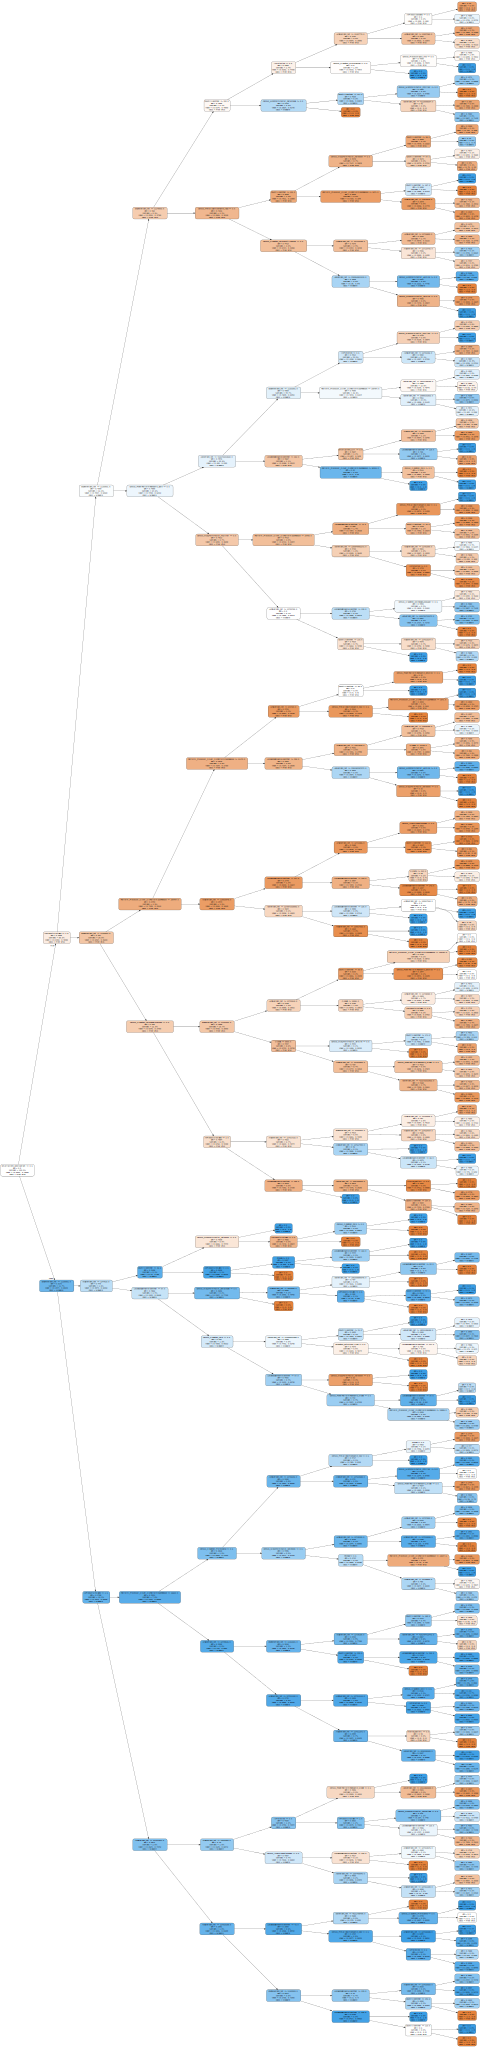

In [562]:
#Miramos al arbol de decisiones
graphviz.Source(dot_data, format = 'png')

In [563]:
##Vamos a ver el Accuracy del modelo

In [564]:
test_prediction = pd.DataFrame(dt.predict(X_test), columns=['Prediction'], index=X_test.index)

In [565]:
results_df = y_test.to_frame().join(test_prediction)

In [566]:
results_df

,HasDetections,Prediction
MachineIdentifier,,
ae847ae2ae52f4c8f80e30729bbe3062,0,0
72661c39b8d122368266398d3af316aa,0,1
af698fbb5c2b4ae511ee5c0da8ffd941,1,0
ec1467171f22efb56db680739f396ad0,0,0
a9e36614b30d533da7df282cc31fd40f,1,1
...,...,...
4ccfb765205a245558958f7cc711e622,0,0
2181f6e7965c01a1548cca1d038b22cc,1,1
4966b49ea8364833793bf12bb753ab24,1,1


In [567]:
results_df['Success'] = (results_df[TARGET] == results_df['Prediction']).astype(int)

In [568]:
results_df['Success'].count()

50000

In [569]:
results_df['Success'].sum()

30415

In [570]:
results_df['Success'].mean()

0.6083

In [571]:
print('Hemos acertado {} registros de un total de {}, por tanto el Accuracy es {}.'.format(results_df['Success'].sum(), results_df['Success'].count(), metrics.accuracy_score(results_df[TARGET], results_df['Prediction'])))

Hemos acertado 30415 registros de un total de 50000, por tanto el Accuracy es 0.6083.


In [572]:
confusion_matrix = pd.crosstab(results_df[TARGET], results_df['Prediction'])

In [573]:
confusion_matrix

Prediction,0,1
HasDetections,,
0,14852,10153
1,9432,15563


In [574]:
TP = confusion_matrix.iloc[1,1]
TN = confusion_matrix.iloc[0,0]
FP = confusion_matrix.iloc[0,1]
FN = confusion_matrix.iloc[1,0]

In [575]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy

0.6083

In [576]:
metrics.accuracy_score(results_df[TARGET], results_df['Prediction'])

0.6083

In [577]:
for i in range(1, 20):
    dt = DecisionTreeClassifier(max_depth=i, random_state=42)
    dt.fit(X_train, y_train)
    train_accuracy = dt.score(X_train, y_train)
    test_accuracy = dt.score(X_test, y_test)
    print('Profundidad del árbol: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Profundidad del árbol: 1. Train: 0.57084 - Test: 0.57018
Profundidad del árbol: 2. Train: 0.57858 - Test: 0.57834
Profundidad del árbol: 3. Train: 0.59608 - Test: 0.59552
Profundidad del árbol: 4. Train: 0.60642 - Test: 0.6042
Profundidad del árbol: 5. Train: 0.61052 - Test: 0.60726
Profundidad del árbol: 6. Train: 0.61268 - Test: 0.60534
Profundidad del árbol: 7. Train: 0.61972 - Test: 0.60806
Profundidad del árbol: 8. Train: 0.62604 - Test: 0.6083
Profundidad del árbol: 9. Train: 0.6323 - Test: 0.60426
Profundidad del árbol: 10. Train: 0.63902 - Test: 0.60556
Profundidad del árbol: 11. Train: 0.64754 - Test: 0.60232
Profundidad del árbol: 12. Train: 0.6576 - Test: 0.5998
Profundidad del árbol: 13. Train: 0.66822 - Test: 0.59904
Profundidad del árbol: 14. Train: 0.68364 - Test: 0.59624
Profundidad del árbol: 15. Train: 0.69768 - Test: 0.59432
Profundidad del árbol: 16. Train: 0.71228 - Test: 0.58854
Profundidad del árbol: 17. Train: 0.73008 - Test: 0.58492
Profundidad del árbol: 18. T

##Intentamos mejorar el modelo añadiendo más variables

In [578]:
#Voy a mirar si hay alguna otro campo interesante para añadir al modelo
#Esta variable a priori parece interesante pero...
df_mw[[TARGET,'HasTpm']].corr()
df_mw['HasTpm'].value_counts() #Solo el 1,2% carece de HTPM así que yo no la cogería.

1    493908
0      6092
Name: HasTpm, dtype: int64

In [579]:
df_mw[[TARGET, 'AVProductStatesIdentifier']].corr()
df_mw['AVProductStatesIdentifier'].value_counts()

53447.0    326463
7945.0      26642
47238.0     18436
62773.0     14931
46413.0      6343
            ...  
2451.0          1
19604.0         1
3193.0          1
26492.0         1
18324.0         1
Name: AVProductStatesIdentifier, Length: 5516, dtype: int64

---------------------------------------
AVProductStatesIdentifier:
                           AVProductStatesIdentifier  HasDetections
AVProductStatesIdentifier                   1.000000       0.116163
HasDetections                               0.116163       1.000000

53447.0    326463
7945.0      26642
47238.0     18436
62773.0     14931
46413.0      6343
            ...  
2451.0          1
19604.0         1
3193.0          1
26492.0         1
18324.0         1
Name: AVProductStatesIdentifier, Length: 5516, dtype: int64
---------------------------------------
GeoNameIdentifier:
                   GeoNameIdentifier  HasDetections
GeoNameIdentifier           1.000000       0.003417
HasDetections               0.003417       1.000000

277.0    86080
211.0    23593
53.0     22977
89.0     20174
240.0    19489
         ...  
280.0        1
231.0        1
113.0        1
221.0        1
132.0        1
Name: GeoNameIdentifier, Length: 268, dtype: int64
--------------------------------------

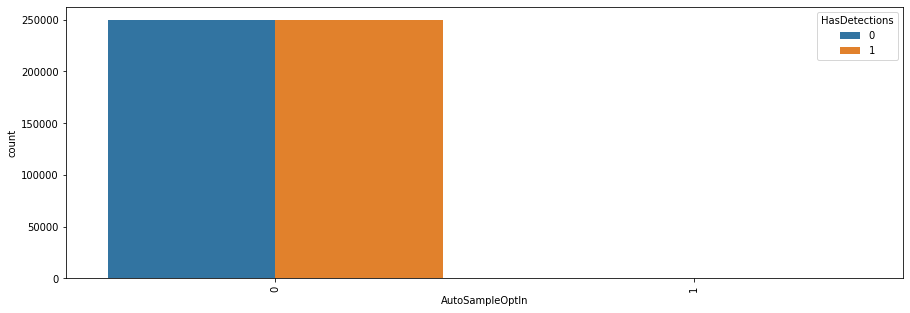

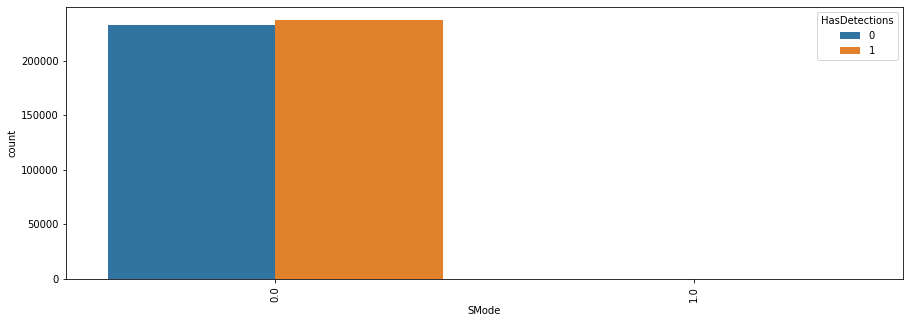

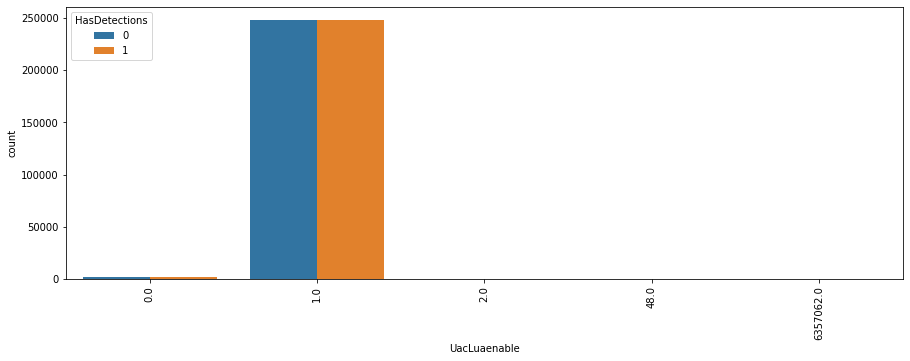

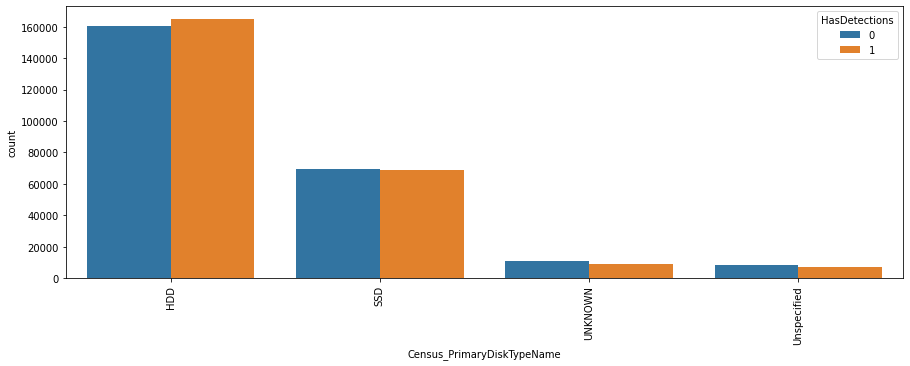

In [580]:
list_columns_explore = ['AVProductStatesIdentifier','GeoNameIdentifier', 'AutoSampleOptIn', 'SMode','UacLuaenable','Census_ProcessorCoreCount','Census_PrimaryDiskTotalCapacity','Census_PrimaryDiskTypeName']
columns_corr(df_mw, list_columns_explore)


---------------------------------------
Census_SystemVolumeTotalCapacity:
                                  Census_SystemVolumeTotalCapacity  HasDetections
Census_SystemVolumeTotalCapacity                          1.000000       0.013595
HasDetections                                             0.013595       1.000000

28542.0     2922
926992.0    2866
476389.0    2380
476324.0    2306
102400.0    2303
            ... 
221517.0       1
580181.0       1
127615.0       1
236484.0       1
470309.0       1
Name: Census_SystemVolumeTotalCapacity, Length: 142051, dtype: int64
---------------------------------------
Census_HasOpticalDiskDrive:
                            Census_HasOpticalDiskDrive  HasDetections
Census_HasOpticalDiskDrive                    1.000000       0.020073
HasDetections                                 0.020073       1.000000

0    461483
1     38517
Name: Census_HasOpticalDiskDrive, dtype: int64
---------------------------------------
Census_TotalPhysicalRAM:
        

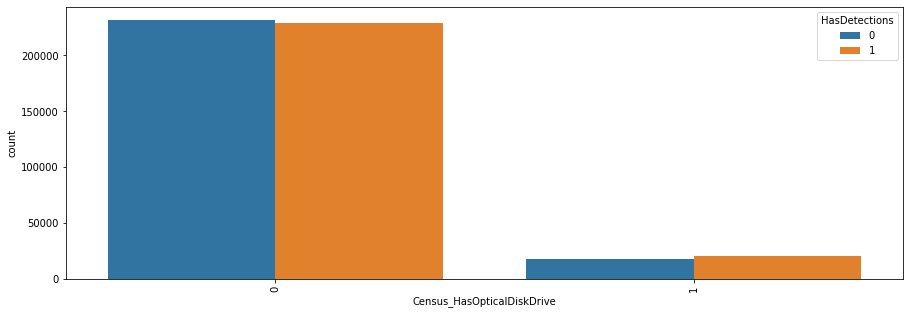

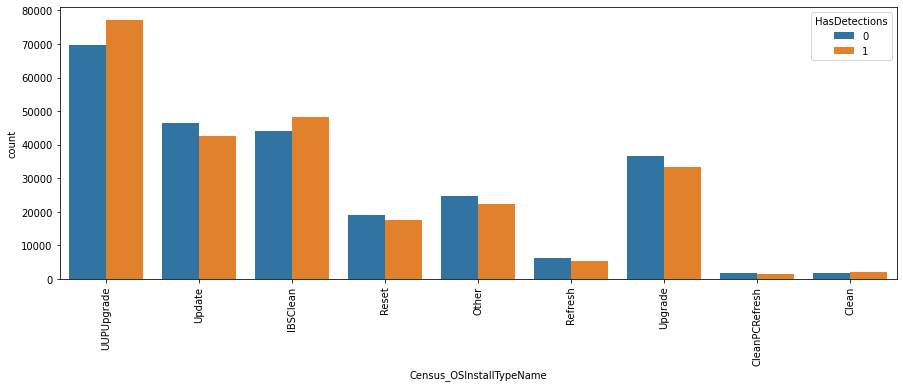

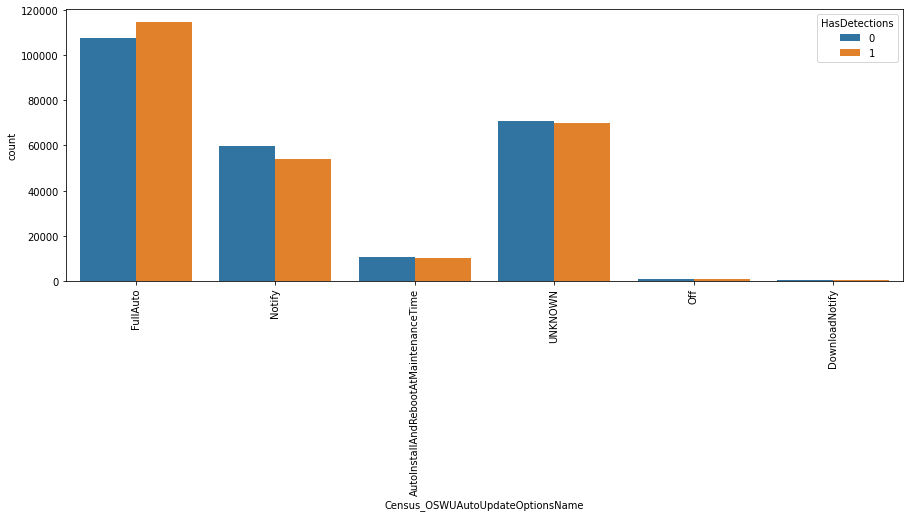

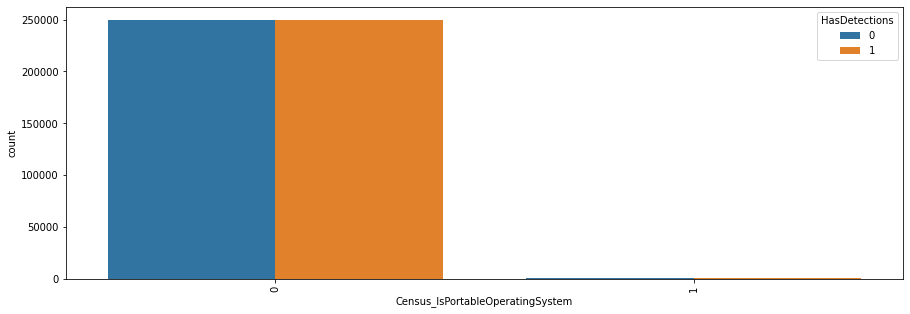

In [581]:
list_columns_explore = ['Census_SystemVolumeTotalCapacity','Census_HasOpticalDiskDrive','Census_TotalPhysicalRAM','Census_OSInstallTypeName','Census_OSWUAutoUpdateOptionsName','Census_OSInstallLanguageIdentifier','Census_OSUILocaleIdentifier','Census_IsPortableOperatingSystem']
columns_corr(df_mw, list_columns_explore)


---------------------------------------
Census_IsFlightsDisabled:
                          Census_IsFlightsDisabled  HasDetections
Census_IsFlightsDisabled                  1.000000      -0.003774
HasDetections                            -0.003774       1.000000

0.0    491060
1.0         7
Name: Census_IsFlightsDisabled, dtype: int64
---------------------------------------
Census_FlightRing:
               HasDetections
HasDetections            1.0

Retail      468299
NOT_SET      16044
Unknown      13701
WIS            606
RP             583
WIF            549
Disabled       217
OSG              1
Name: Census_FlightRing, dtype: int64
---------------------------------------
Census_IsSecureBootEnabled:
                            Census_IsSecureBootEnabled  HasDetections
Census_IsSecureBootEnabled                    1.000000      -0.002487
HasDetections                                -0.002487       1.000000

0    257281
1    242719
Name: Census_IsSecureBootEnabled, dtype: int64
----

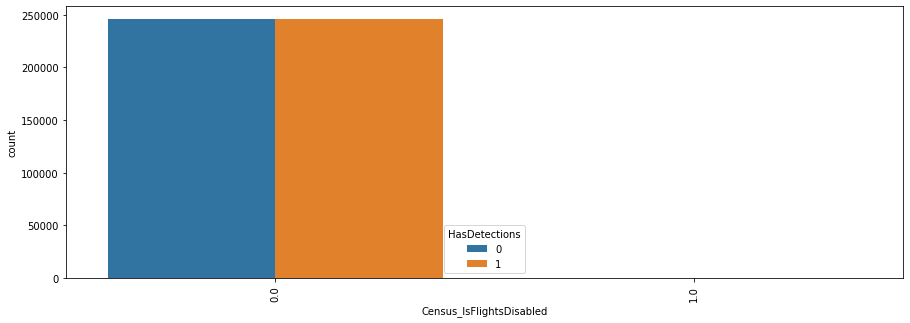

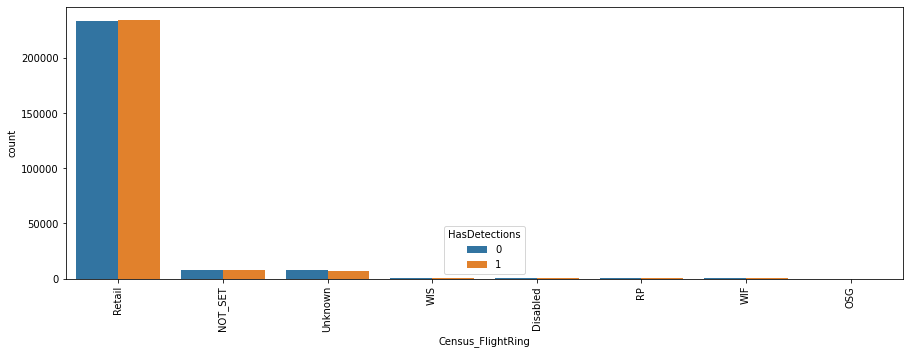

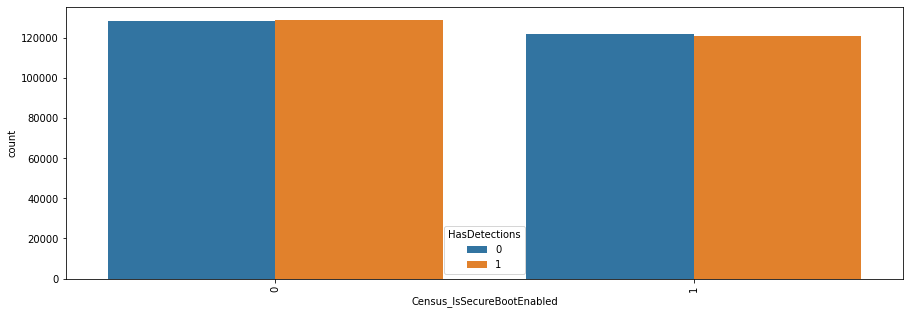

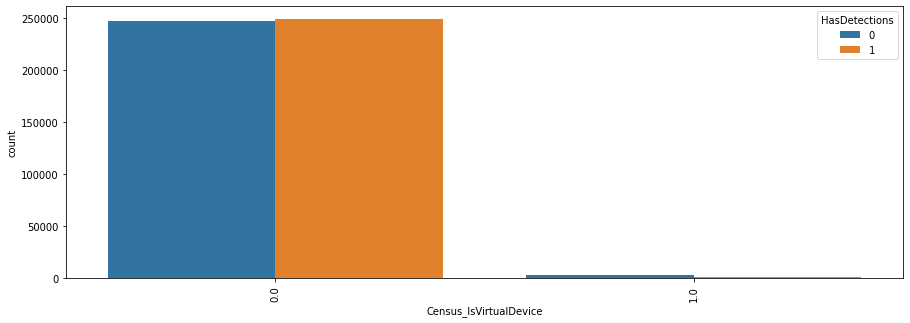

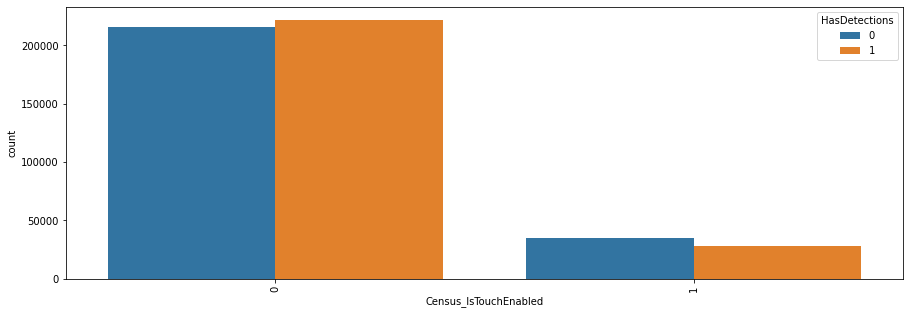

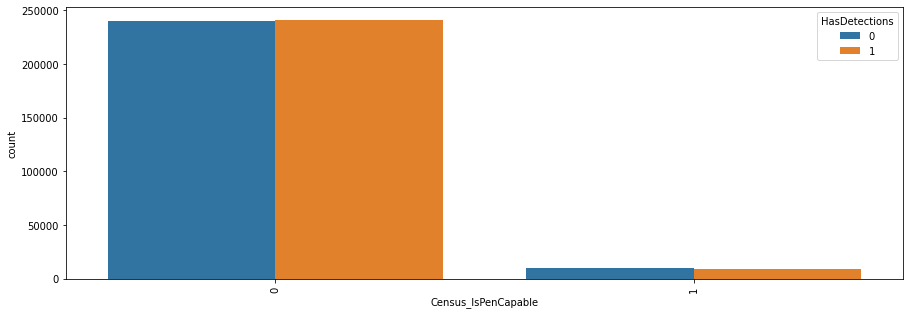

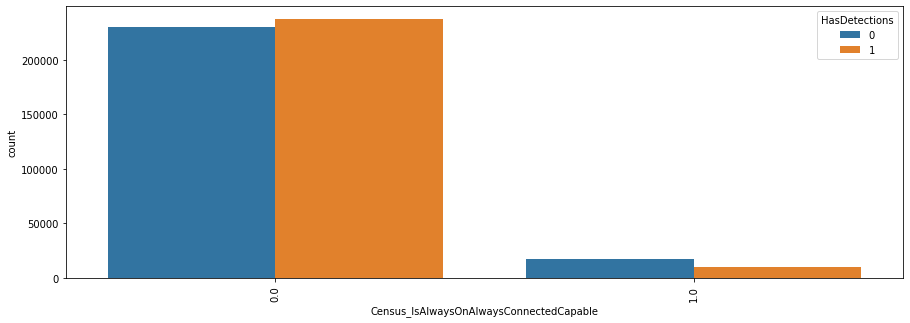

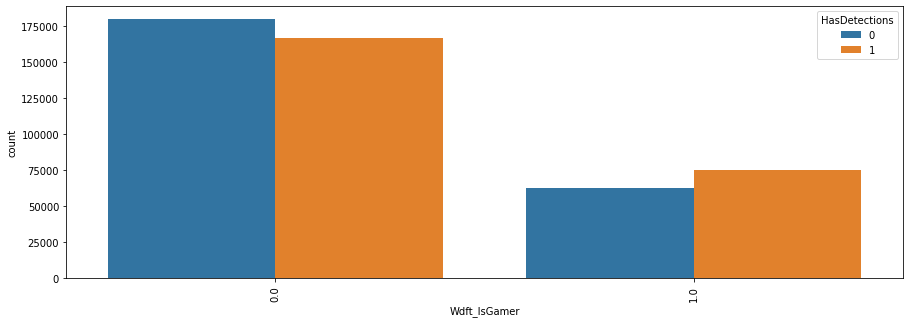

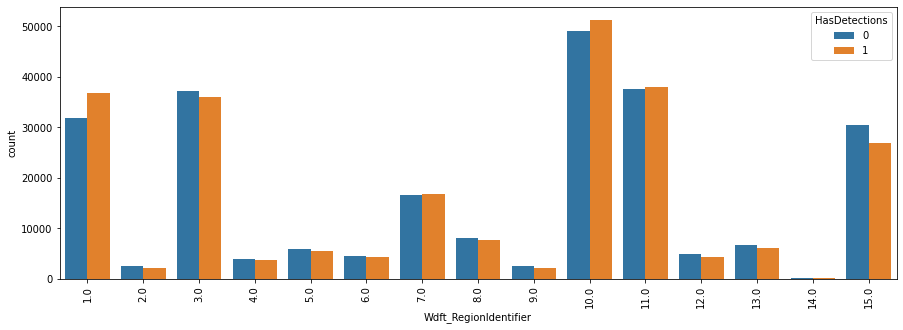

In [582]:
list_columns_explore = ['Census_IsFlightsDisabled','Census_FlightRing','Census_IsSecureBootEnabled','Census_IsVirtualDevice','Census_IsTouchEnabled','Census_IsPenCapable','Census_IsAlwaysOnAlwaysConnectedCapable','Wdft_IsGamer','Wdft_RegionIdentifier']
columns_corr(df_mw, list_columns_explore)

In [583]:
#Estas son las variables que voy a añadir al nuevo modelo. 
list_news_num = ['MachineIdentifier','Census_ProcessorCoreCount','Census_HasOpticalDiskDrive','Census_IsTouchEnabled','Census_IsAlwaysOnAlwaysConnectedCapable','Wdft_IsGamer']
list_news_cat = ['MachineIdentifier','Census_PrimaryDiskTypeName','Census_OSInstallTypeName','Census_OSWUAutoUpdateOptionsName']

In [584]:
df_mw_news_num = df_mw_news_cat = pd.DataFrame()
df_mw_news_num = df_mw[list_news_num].copy()
df_mw_news_num.set_index('MachineIdentifier', inplace= True)
df_mw_news_num.isnull().sum() #Miramos los nulos. de las númericas

Census_ProcessorCoreCount                   2347
Census_HasOpticalDiskDrive                     0
Census_IsTouchEnabled                          0
Census_IsAlwaysOnAlwaysConnectedCapable     4040
Wdft_IsGamer                               16950
dtype: int64

In [585]:
#Le asigno un valor extremo a los nulos.
df_mw_news_num.fillna(-1, inplace=True)

In [586]:
df_mw_news_num.isnull().sum() #Miramos otra vez los nulos. Perfecto.


Census_ProcessorCoreCount                  0
Census_HasOpticalDiskDrive                 0
Census_IsTouchEnabled                      0
Census_IsAlwaysOnAlwaysConnectedCapable    0
Wdft_IsGamer                               0
dtype: int64

In [587]:
df_mw_news_cat =  df_mw[list_news_cat].copy()
df_mw_news_cat.set_index('MachineIdentifier', inplace= True)

In [588]:
df_mw_news_cat.isnull().sum() #Miramos los nulos.

Census_PrimaryDiskTypeName          709
Census_OSInstallTypeName              0
Census_OSWUAutoUpdateOptionsName      0
dtype: int64

In [589]:
df_mw_news_cat['Census_PrimaryDiskTypeName'].value_counts()

HDD            325429
SSD            138155
UNKNOWN         20083
Unspecified     15624
Name: Census_PrimaryDiskTypeName, dtype: int64

In [590]:
df_mw_news_cat.fillna('isnan', inplace=True)

In [591]:
df_mw_news_cat.isnull().sum() #Miramos los nulos.

Census_PrimaryDiskTypeName          0
Census_OSInstallTypeName            0
Census_OSWUAutoUpdateOptionsName    0
dtype: int64

In [592]:
df_mw_news_cat= OHE('Census_PrimaryDiskTypeName',df_mw_news_cat)
df_mw_news_cat= OHE('Census_OSInstallTypeName',df_mw_news_cat)
df_mw_news_cat= OHE('Census_OSWUAutoUpdateOptionsName',df_mw_news_cat)

In [593]:
df_mw_news_cat

,Census_PrimaryDiskTypeName_HDD,Census_PrimaryDiskTypeName_SSD,Census_PrimaryDiskTypeName_UNKNOWN,Census_PrimaryDiskTypeName_Unspecified,Census_PrimaryDiskTypeName_isnan,Census_OSInstallTypeName_Clean,Census_OSInstallTypeName_CleanPCRefresh,Census_OSInstallTypeName_IBSClean,Census_OSInstallTypeName_Other,Census_OSInstallTypeName_Refresh,Census_OSInstallTypeName_Reset,Census_OSInstallTypeName_UUPUpgrade,Census_OSInstallTypeName_Update,Census_OSInstallTypeName_Upgrade,Census_OSWUAutoUpdateOptionsName_AutoInstallAndRebootAtMaintenanceTime,Census_OSWUAutoUpdateOptionsName_DownloadNotify,Census_OSWUAutoUpdateOptionsName_FullAuto,Census_OSWUAutoUpdateOptionsName_Notify,Census_OSWUAutoUpdateOptionsName_Off,Census_OSWUAutoUpdateOptionsName_UNKNOWN
MachineIdentifier,,,,,,,,,,,,,,,,,,,,
f1cd864e97bae82bdf96523e1a539121,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
fd5ba6f5b75325ec0423a6c67cc75942,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4e628391e7cc7c482fb3286f486dbd25,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
270a2e9d028144a4df12a9e3da79fba5,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
06ca8fa8d32c2abdc5b3577d676b3269,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
a739cacc292f3f1e745827c1ca6c6ada,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
a4c232d528d98343e8f1b73650da7b82,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
fd16cd542d660848d272e4552bcccb1e,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [594]:
df_mw_news_fields =  pd.merge(df_mw_news_num, df_mw_news_cat, how='left', left_index=True, right_index=True)

#df_df_mw_categoric1_mw = pd.merge(df_mw_categoric1, df_mw[['MachineIdentifier','IsBeta','CountryIdentifier','LocaleEnglishNameIdentifier','OsBuild','OsSuite','IsProtected','Firewall','Census_IsSecureBootEnabled','AVProductsInstalled','AVProductsEnabled']].set_index('MachineIdentifier'), how='left', left_index=True, right_index=True)

In [595]:
df_mw_news_fields.shape

(500000, 25)

In [596]:
df_final_modelo = pd.merge(df_df_mw_categoric1_mw, df_mw_news_fields, how='left', left_index=True, right_index=True)

In [597]:
df_final_modelo.shape

(500000, 95)

In [598]:
test_prediction, y_test, X_test, y_val, X_val, y_train, X_train = training(TARGET, df_final_modelo) #Lanzamos el modelo.
results_df = y_test.to_frame().join(test_prediction)

In [599]:
results_df['Success'] = (results_df[TARGET] == results_df['Prediction']).astype(int)

In [600]:
confusion_matrix = pd.crosstab(results_df[TARGET], results_df['Prediction'])

In [601]:
print('Hemos acertado {} registros de un total de {}, por tanto el Accuracy es {}.'.format(results_df['Success'].sum(), results_df['Success'].count(), results_df['Success'].mean()))

Hemos acertado 30711 registros de un total de 50000, por tanto el Accuracy es 0.61422.


In [602]:
metrics.accuracy_score(results_df[TARGET], results_df['Prediction']) #Hemos mejorado el modelo.

0.61422